# Neural Nets - Covid_19

* Use only US, Spain, Italy, and Canada for test.
* Use 5-fold cross validation for validation purposes on the training dataset
* Using the 5-fold cross validation compare the following problem settings:
  * S1: Two hidden layers with 15 neurons in each layer (current setting)
  * S2: Two hidden layers with 10 neurons in each layer
  * S3: Two hidden layers with 10 neurons in the first layer and 15 neurons in the second layer
  * S4: Two hidden layers with 15 neurons in the first layer and 10 neurons in the second layer
  * S5: Three hidden layers with 15 neurons in each layer
  * S6: Three hidden layers with 10 neurons in each layer
  * S7: One hidden layer with 10 neurons
  * S8: One hidden layer with 15 neurons
* Compare the above settings using the score (R2) metric and select the best setting
* Use the neural network with the best setting to predict the new cases of COVID-19 for US, Spain, Italy, and Canada.    
  Measure their performance in terms of average absolute error. Draw a bar chart to compare the corresponding errors.
* Report all the performances of cross validation in a proper table.


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  5 20:53:12 2022

@author: jl
"""

import csv

# Data import
glob = dict()       
with open('covid19_global_dataset.csv', newline='') as csvfile:
    datareader = csv.reader(csvfile)
    for r in datareader:
        c = r[0]
        if c=='week':
            weekID = r[1:]
        else:
            tmp = []
            for i in range(0,21):
                tmp.append(0)
            darray = r[1:]
            for i in range(0,len(darray)):
                t = int(weekID[i])
                d = int(darray[i])
                if t<21:
                    tmp[t] += d
            glob[c] = tmp    
            

In [2]:
def prepare_data(data):
    # New Cases
    allNews = []
    for c in data:
        tmp = data[c]
        tmp2 = [tmp[0]]
        allNews.append(tmp[0])
        for i in range(1,len(tmp)):
            tmp2.append(tmp[i] - tmp[i-1])
            allNews.append(tmp[i] - tmp[i-1])
        data[c] = tmp2


    # Build Dataset
    X = []
    Y = []
    step = 10
    for c in data:
        tmp = data[c]
        for j in range(0,len(tmp)-step-1):
            sdata = sum(tmp[j:j+step])
            if sdata>0:
                X.append(tmp[j:j+step])
                Y.append(tmp[j+step])
    
    return X, Y

In [3]:
test = {}
test["US"] = glob.pop("US")
test["Spain"] = glob.pop("Spain")
test["Italy"] = glob.pop("Italy")
test["Canada"] = glob.pop("Canada")

In [4]:
Xtrain, Ytrain = prepare_data(glob)

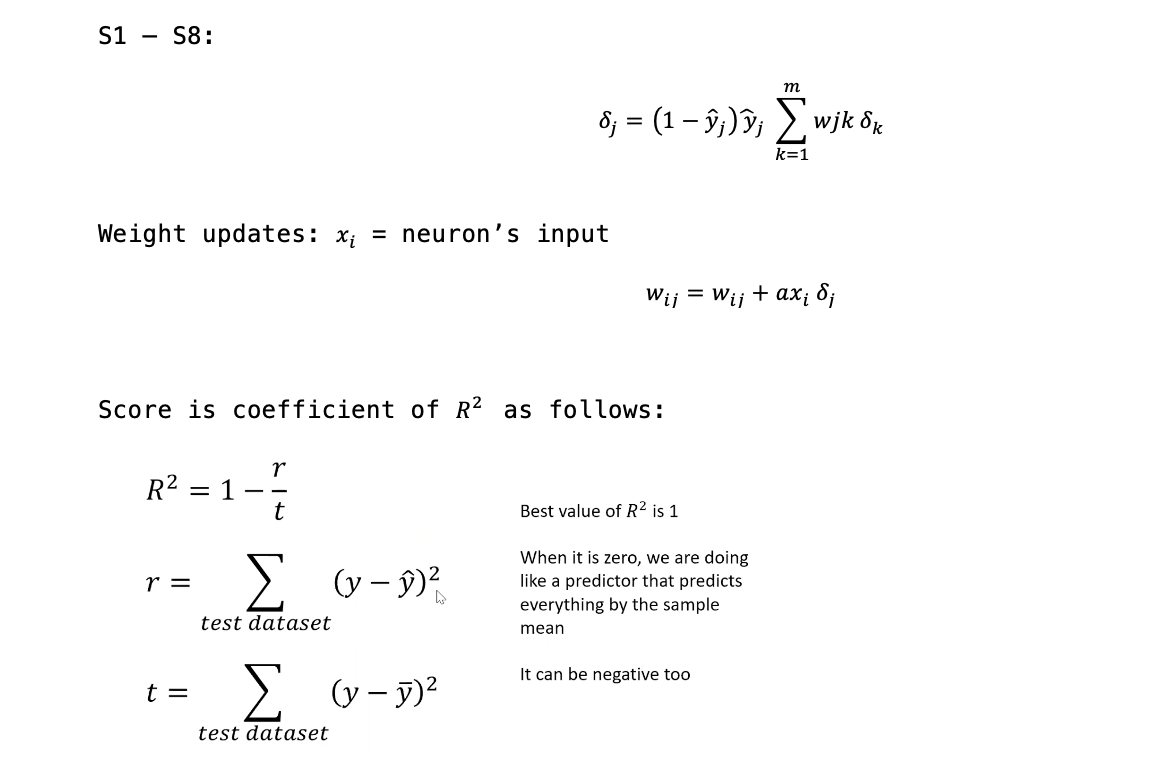

In [5]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error

FOLD = 5
R2_SCORES = []
MODEL_LAYERS = []
SCORING_METHOD = "r2"

S1 = MLPRegressor(hidden_layer_sizes=(15, 15),random_state=1,max_iter=2000)
S2 = MLPRegressor(hidden_layer_sizes=(10, 10),random_state=1,max_iter=2000)
S3 = MLPRegressor(hidden_layer_sizes=(10, 15),random_state=1,max_iter=2000)
S4 = MLPRegressor(hidden_layer_sizes=(15, 10),random_state=1,max_iter=2000)
S5 = MLPRegressor(hidden_layer_sizes=(15, 15, 15),random_state=1,max_iter=2000)
S6 = MLPRegressor(hidden_layer_sizes=(10, 10, 10),random_state=1,max_iter=2000)
S7 = MLPRegressor(hidden_layer_sizes=(10),random_state=1,max_iter=2000)
S8 = MLPRegressor(hidden_layer_sizes=(15),random_state=1,max_iter=2000)

models = [S1, S2, S3, S4, S5, S6, S7, S8]

for model in models:
    results = cross_validate(estimator=model,
                               X=Xtrain,
                               y=Ytrain,
                               cv=FOLD,
                               scoring=SCORING_METHOD,
                               return_train_score=True)
    r2 = np.mean(results["test_score"])
    R2_SCORES.append(r2)
    MODEL_LAYERS.append(str(model.hidden_layer_sizes))

In [6]:
for i, j in zip(MODEL_LAYERS, R2_SCORES):
    print(i, " --> ", j)

(15, 15)  -->  0.7834369450220723
(10, 10)  -->  0.8062416689890292
(10, 15)  -->  0.7980480078053006
(15, 10)  -->  0.7936494907864421
(15, 15, 15)  -->  0.7546361734235025
(10, 10, 10)  -->  0.7805797336713745
10  -->  0.8004780772684914
15  -->  0.8101451829246591


In [7]:
final_model = S8
final_model.fit(Xtrain, Ytrain)

MLPRegressor(hidden_layer_sizes=15, max_iter=2000, random_state=1)

In [8]:
ERRORS = []
SCORES = []
PREDICTIONS = dict()
CONTRIES = ["US", "Spain", "Italy", "Canada"]

for cont in CONTRIES:
    data = dict()
    data[cont] = test[cont]
    X, Y = prepare_data(data)
    Ypred = final_model.predict(X)
    r2 = r2_score(Y, Ypred)
    error = mean_squared_error(Y, Ypred)
    ERRORS.append(error)
    SCORES.append(r2)
    PREDICTIONS[cont] = Ypred

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\jl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


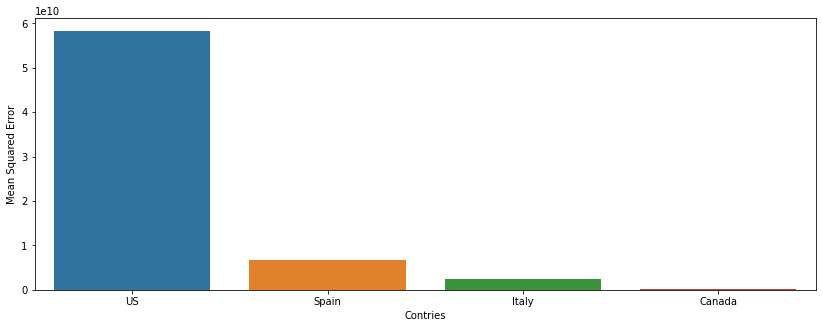

In [10]:
plt.figure(figsize=(14, 5))
sns.barplot(CONTRIES, ERRORS)
# plt.ylim(0.7, 0.82)
plt.ylabel("Mean Squared Error")
plt.xlabel("Contries")
plt.show()

In [14]:
import pandas as pd

df_models = pd.DataFrame({"Model": MODEL_LAYERS, "R2 Score": R2_SCORES})
display(df_models)

,Model,R2 Score
0,"(15, 15)",0.783437
1,"(10, 10)",0.806242
2,"(10, 15)",0.798048
3,"(15, 10)",0.793649
4,"(15, 15, 15)",0.754636
5,"(10, 10, 10)",0.780580
6,10,0.800478
7,15,0.810145


In [13]:
df_cont = pd.DataFrame({"Country": CONTRIES, "R2 Score": SCORES, "MSE": ERRORS})
display(df_cont)

,Country,R2 Score,MSE
0,US,0.849778,5.829782e+10
1,Spain,0.554996,6.743901e+09
2,Italy,0.585828,2.394247e+09
3,Canada,0.858046,1.667881e+08
